In [40]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from IF import *
from proutils import *
from joblib import Parallel, delayed
from torch.utils import data
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F


df = pd.read_csv('data/loan_approval_dataset.csv')


In [30]:
df=df.drop('loan_id',axis=1)
df[' education'] = LabelEncoder().fit_transform(df[' education'])
df[' self_employed'] = LabelEncoder().fit_transform(df[' self_employed'])
df[' loan_status'] = LabelEncoder().fit_transform(df[' loan_status'])
y = df[' loan_status']

scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=[' loan_status']))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
train_set = data.TensorDataset(X_train, y_train)
test_set = data.TensorDataset(X_test, y_test)


In [34]:
class LoanApprovalNN(nn.Module):
    def __init__(self, input_size):
        super(LoanApprovalNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, 16)
        self.hidden2 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, return_embedding=False):
        x = self.relu(self.hidden1(x))
        embedding = self.relu(self.hidden2(x))
        if return_embedding:
            return embedding
        x = self.sigmoid(self.output(embedding))
        return x

# Fit model function
def fit_model(X, y, emb=False):
    model = LoanApprovalNN(X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Training loop
    epochs = 100
    for epoch in range(epochs):
        model.train()
        
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
    
    if emb:
        model.eval()
        with torch.no_grad():
            embeddings = model(X, return_embedding=True)
        return embeddings
    return model

In [35]:
network=fit_model(X_train, y_train)
# torch.save(network.state_dict(), 'data/main_loan.pth')

Epoch [10/100], Loss: 0.6803
Epoch [20/100], Loss: 0.6705
Epoch [30/100], Loss: 0.6594
Epoch [40/100], Loss: 0.6465
Epoch [50/100], Loss: 0.6317
Epoch [60/100], Loss: 0.6145
Epoch [70/100], Loss: 0.5946
Epoch [80/100], Loss: 0.5717
Epoch [90/100], Loss: 0.5459
Epoch [100/100], Loss: 0.5173


In [89]:
network = LoanApprovalNN(X_train.shape[1])
network.load_state_dict(torch.load('data/main_loan.pth', weights_only=True))
network.eval()
print("Model Loaded")

Model Loaded


In [90]:
network.eval()
with torch.no_grad():
    predictions = network(X_test)
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary
    accuracy = (predictions == y_test).sum().item() / len(y_test)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 91.10%


In [37]:
mod_pred = (network(X_test).detach()>0.5).int().numpy()
DEVICE= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class BinClassObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.binary_cross_entropy(outputs, batch[1])

    def train_regularization(self, params):
        return L2_WEIGHT * torch.square(params.norm())

    def test_loss(self, model, params, batch):
        outputs = model(batch[0])
        return F.binary_cross_entropy(outputs, batch[1])
torch.manual_seed(42)    
module = LiSSAInfluenceModule(
    model=network,
    objective=BinClassObjective(),
    train_loader=data.DataLoader(train_set, batch_size=32),
    test_loader=data.DataLoader(test_set, batch_size=32),
    device=DEVICE,
    damp=0.001,
    repeat= 1,
    depth=1800,
    scale= 10,
)

In [38]:
test_idxs = list(range(len(y_test)))
train_idxs = list(range(len(y_train)))

In [41]:
def compute_influence(test_idx):
    # print(f'Compute influence for test point {test_idx}')
    influences = module.influences(train_idxs=train_idxs, test_idxs=[test_idx])
    return influences.numpy()

# Parallel computation of influence scores
num_cores = -1

influence_scores = Parallel(n_jobs=num_cores)(delayed(compute_influence)(test_idx) for test_idx in tqdm(test_idxs))

# Step 7: Save the influence scores to a file
influence_scores = np.array(influence_scores)
# np.save('influence_scores_loan.npy', influence_scores)
print('Influence scores saved to influence_scores.npy')

100%|██████████| 1708/1708 [20:03<00:00,  1.42it/s]


Influence scores saved to influence_scores.npy


In [88]:
influence_scores=np.load("influence_scores_loan.npy")

In [49]:
fit_model(X_test[mglop[1]], torch.tensor(mod_pred[mglop[1]], dtype=torch.float32))

Epoch [10/100], Loss: 0.7543
Epoch [20/100], Loss: 0.7313
Epoch [30/100], Loss: 0.7138
Epoch [40/100], Loss: 0.6984
Epoch [50/100], Loss: 0.6818
Epoch [60/100], Loss: 0.6630
Epoch [70/100], Loss: 0.6408
Epoch [80/100], Loss: 0.6150
Epoch [90/100], Loss: 0.5842
Epoch [100/100], Loss: 0.5508


LoanApprovalNN(
  (hidden1): Linear(in_features=11, out_features=16, bias=True)
  (hidden2): Linear(in_features=16, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [91]:
def surrogate_fidelity(prototypes):
    smodel = fit_model(X_test[prototypes], torch.tensor(mod_pred[prototypes], dtype=torch.float32))

    # Evaluate the model on test data
    smodel.eval()
    with torch.no_grad():
        outputs = (smodel(X_test).detach()>0.5).int().numpy()
        accuracy = (outputs == mod_pred).sum().item() / len(y_test)
    return accuracy

Epoch [10/100], Loss: 0.6193
Epoch [20/100], Loss: 0.5833
Epoch [30/100], Loss: 0.5402
Epoch [40/100], Loss: 0.4894
Epoch [50/100], Loss: 0.4328
Epoch [60/100], Loss: 0.3741
Epoch [10/100], Loss: 0.6629
Epoch [70/100], Loss: 0.3204
Epoch [20/100], Loss: 0.6411
Epoch [80/100], Loss: 0.2726
Epoch [30/100], Loss: 0.6173
Epoch [90/100], Loss: 0.2328
Epoch [40/100], Loss: 0.5918
Epoch [100/100], Loss: 0.2003
Epoch [50/100], Loss: 0.5651
Epoch [60/100], Loss: 0.5376
Epoch [10/100], Loss: 0.6131
Epoch [70/100], Loss: 0.5092
Epoch [20/100], Loss: 0.5956
Epoch [80/100], Loss: 0.4807
Epoch [90/100], Loss: 0.4523
Epoch [30/100], Loss: 0.5751
Epoch [100/100], Loss: 0.4245
Epoch [40/100], Loss: 0.5480
Epoch [50/100], Loss: 0.5160
Epoch [60/100], Loss: 0.4783
Epoch [70/100], Loss: 0.4362
Epoch [10/100], Loss: 0.7067
Epoch [10/100], Loss: 0.5985
Epoch [80/100], Loss: 0.3946
Epoch [20/100], Loss: 0.6716
Epoch [20/100], Loss: 0.5855
Epoch [90/100], Loss: 0.3586
Epoch [30/100], Loss: 0.6362
Epoch [30/10

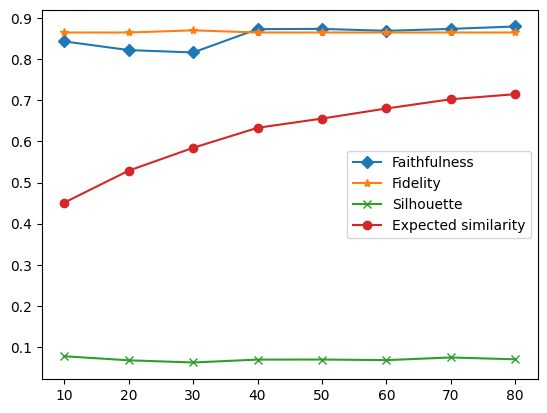

In [53]:
#Experiments with MGloP
# mglop=Parallel(n_jobs=-1)(delayed(find_representative_samples)(X_test, X_train, influence_scores,i, 20) for i in tqdm(range(10,81,10)))
accs=[]
fids=[]
sil=[]
sim=[]
def compute_metrics(i):
    acc = nearest_medoid_accuracy(X_test, mod_pred, mglop[i])
    fid=surrogate_fidelity(mglop[i])
    sil = compute_prototype_silhouette_score(X_test, mglop[i])
    labels = cluster_by_prototypes(X_test, mglop[i])
    sim = expected_inter_cluster_similarity(X_test, labels)
    return acc,fid, sil, sim

# Parallel computation
results = Parallel(n_jobs=64)(delayed(compute_metrics)(i) for i in range(len(mglop)))

# Unpack results into separate lists
accs,fids, sil, sim = zip(*results)
plt.plot(range(10, 81, 10), accs, marker='D', label='Faithfulness')
plt.plot(range(10, 81, 10), fids, marker='*', label='Fidelity')
plt.plot(range(10, 81, 10), sil, marker='x', label='Silhouette')
plt.plot(range(10, 81, 10), sim, marker='o', label='Expected similarity')
plt.legend()
plt.show()

In [57]:
embeddings=network(X_test, return_embedding=True)
dmem=torch.load('data/embeds_DMloan.pt')

/tmp/ipykernel_2814657/184110675.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dmem=torch.load('data/embeds_DMloan.pt')


In [107]:
X_test.numpy()

array([[ 1.4750671 , -0.99555916, -1.0072882 , ...,  1.1454711 ,
         0.06302469,  0.7149069 ],
       [-0.29410172, -0.99555916, -1.0072882 , ...,  1.0315356 ,
         0.2937258 ,  0.53028035],
       [ 0.29562125, -0.99555916, -1.0072882 , ...,  2.55827   ,
         1.4692029 ,  0.49950927],
       ...,
       [-0.29410172, -0.99555916, -1.0072882 , ...,  0.4618587 ,
         0.07401046, -0.26976773],
       [-0.88382465, -0.99555916, -1.0072882 , ..., -0.905366  ,
        -0.8048509 , -0.1774545 ],
       [-1.4735476 , -0.99555916, -1.0072882 , ...,  0.27956206,
         2.0404627 ,  0.19179848]], dtype=float32)

In [110]:
explainer = ProtodashExplainer()
weights, protodash, _ = explainer.explain(X_test.numpy(), X_test.numpy(), m=80, kernelType = 'Gaussian')

In [76]:
embeddings

tensor([[0.0869, 0.9527, 0.0000,  ..., 0.0000, 0.2548, 0.3679],
        [0.8082, 0.1033, 0.0000,  ..., 0.4854, 0.7203, 0.3540],
        [0.1412, 0.9303, 0.0000,  ..., 0.4278, 0.3217, 0.1413],
        ...,
        [0.0000, 1.0732, 0.0000,  ..., 0.0000, 0.4683, 0.0000],
        [1.0357, 0.1495, 0.0000,  ..., 0.0000, 0.5687, 0.6518],
        [0.4091, 0.3785, 0.0000,  ..., 0.1737, 0.5667, 0.1967]],
       grad_fn=<ReluBackward0>)

In [112]:
from aix360.algorithms.protodash import ProtodashExplainer

N_values=range(10,101, 10)
def generate_prototypes(N):
    explainer = ProtodashExplainer()
    weights, protodash, _ = explainer.explain(X_test, X_test, m=N, kernelType = 'Gaussian')
    
    return {
        "mglop": find_representative_samples(X_test, X_train, influence_scores, N, 20),
        "dknn": find_prototypes(embeddings.detach(), mod_pred, N),
        "dm": find_prototypes(dmem, mod_pred, N),
        "protodash": protodash
    }

n_jobs = -1 
all_protos = Parallel(n_jobs=n_jobs)(
    delayed(generate_prototypes)(N)
    for N in tqdm(N_values)
)

100%|██████████| 10/10 [00:00<00:00, 7727.16it/s]


In [114]:
all_protos_np=np.array(all_protos)
mglop_ev=[]
protodash_ev=[]
dknn_ev=[]
dmodels_ev=[]
for i in range(len(all_protos_np)):
    mglop_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[0]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[0]), surrogate_fidelity(list(all_protos_np[i].values())[0])])
    dmodels_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[2]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[2]), surrogate_fidelity(list(all_protos_np[i].values())[2])])   
    dknn_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[1]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[1]),surrogate_fidelity(list(all_protos_np[i].values())[1])])
    protodash_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[3]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[3]), surrogate_fidelity(list(all_protos_np[i].values())[3])])
               


Epoch [10/100], Loss: 0.7813
Epoch [20/100], Loss: 0.7343
Epoch [30/100], Loss: 0.6938
Epoch [40/100], Loss: 0.6557
Epoch [50/100], Loss: 0.6120
Epoch [60/100], Loss: 0.5641
Epoch [70/100], Loss: 0.5138
Epoch [80/100], Loss: 0.4611
Epoch [90/100], Loss: 0.4072
Epoch [100/100], Loss: 0.3534
Epoch [10/100], Loss: 0.7279
Epoch [20/100], Loss: 0.6917
Epoch [30/100], Loss: 0.6638
Epoch [40/100], Loss: 0.6426
Epoch [50/100], Loss: 0.6228
Epoch [60/100], Loss: 0.6032
Epoch [70/100], Loss: 0.5828
Epoch [80/100], Loss: 0.5622
Epoch [90/100], Loss: 0.5397
Epoch [100/100], Loss: 0.5131
Epoch [10/100], Loss: 0.5459
Epoch [20/100], Loss: 0.5236
Epoch [30/100], Loss: 0.5009
Epoch [40/100], Loss: 0.4773
Epoch [50/100], Loss: 0.4522
Epoch [60/100], Loss: 0.4226
Epoch [70/100], Loss: 0.3897
Epoch [80/100], Loss: 0.3516
Epoch [90/100], Loss: 0.3128
Epoch [100/100], Loss: 0.2769
Epoch [10/100], Loss: 0.7282
Epoch [20/100], Loss: 0.6878
Epoch [30/100], Loss: 0.6458
Epoch [40/100], Loss: 0.6045
Epoch [50/1

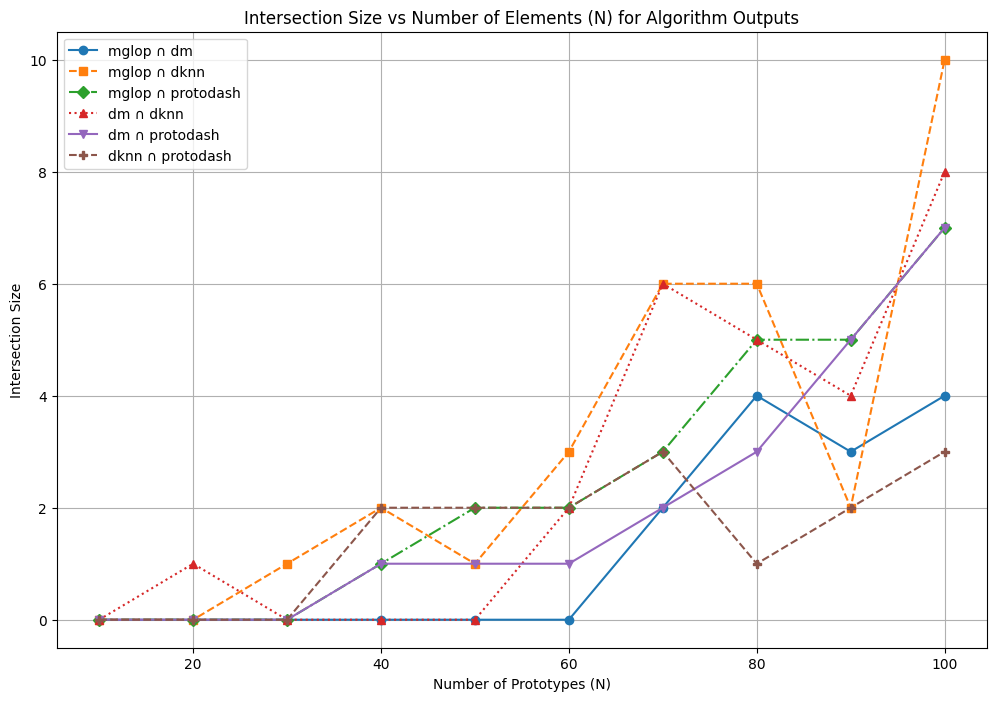

In [129]:
algorithms = ['mglop', 'dm', 'dknn', 'protodash']
N_values = range(10, 101, 10)  # Increasing N values from 10 to 80
intersections = {f"{algo1} ∩ {algo2}": [] for i, algo1 in enumerate(algorithms) for algo2 in algorithms[i + 1:]}


# Extract intersections between algorithm outputs
for i, outputs in enumerate(all_protos):
    for j, algo1 in enumerate(algorithms):
        for algo2 in algorithms[j + 1:]:
            intersection_size = len(set(outputs[algo1]) & set(outputs[algo2]))
            intersections[f"{algo1} ∩ {algo2}"].append(intersection_size)

# Plotting the results
line_styles = ['-', '--', '-.', ':', '-', '--']
markers = ['o', 's', 'D', '^', 'v', 'P']

plt.figure(figsize=(12, 8))
for (label, sizes), linestyle, marker in zip(intersections.items(), line_styles, markers):
    plt.plot(N_values, sizes, linestyle=linestyle, marker=marker, label=label)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Intersection Size")
plt.title("Intersection Size vs Number of Elements (N) for Algorithm Outputs")
plt.legend()
plt.grid(True)

# Save the plot as a PDF
# plt.savefig("Figures/intersection_plot.pdf", format="pdf")

# Show the plot
plt.show()

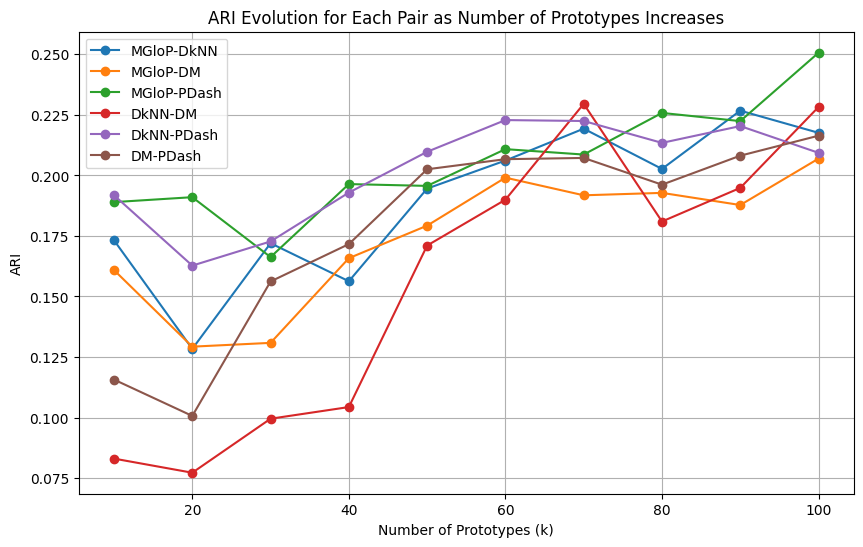

In [130]:
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cdist

def assign_clusters(X, prototypes):

    # Compute distance from each point to each prototype
    distances = cdist(X, prototypes, metric='euclidean')
    
    # Assign each point to the cluster with minimum distance
    labels = np.argmin(distances, axis=1)
    return labels

pairwise_aris = {
    "MGloP-DkNN": [],
    "MGloP-DM": [],
    "MGloP-PDash": [],
    "DkNN-DM": [],
    "DkNN-PDash": [],
    "DM-PDash": []
}

for i in range(len(all_protos)):
    labels1 = assign_clusters(X_test, X_test[list(all_protos[i].values())[0]])
    labels2 = assign_clusters(X_test, X_test[list(all_protos[i].values())[1]])
    labels3 = assign_clusters(X_test, X_test[list(all_protos[i].values())[2]])
    labels4 = assign_clusters(X_test, X_test[list(all_protos[i].values())[3]])
    
    
    # Compute ARIs for all pairs
    ari_12 = adjusted_rand_score(labels1, labels2)
    ari_13 = adjusted_rand_score(labels1, labels3)
    ari_14 = adjusted_rand_score(labels1, labels4)
    ari_23 = adjusted_rand_score(labels2, labels3)
    ari_24 = adjusted_rand_score(labels2, labels4)
    ari_34 = adjusted_rand_score(labels3, labels4)
    
    # Append results
    pairwise_aris["MGloP-DkNN"].append(ari_12)
    pairwise_aris["MGloP-DM"].append(ari_13)
    pairwise_aris["MGloP-PDash"].append(ari_14)
    pairwise_aris["DkNN-DM"].append(ari_23)
    pairwise_aris["DkNN-PDash"].append(ari_24)
    pairwise_aris["DM-PDash"].append(ari_34)

# Plot the ARI evolution for each pair
plt.figure(figsize=(10, 6))
for pair_name, ari_values in pairwise_aris.items():
    plt.plot(N_values, ari_values, marker='o', label=pair_name)

plt.title('ARI Evolution for Each Pair as Number of Prototypes Increases')
plt.xlabel('Number of Prototypes (k)')
plt.ylabel('ARI')
plt.grid(True)
plt.legend()
plt.show()

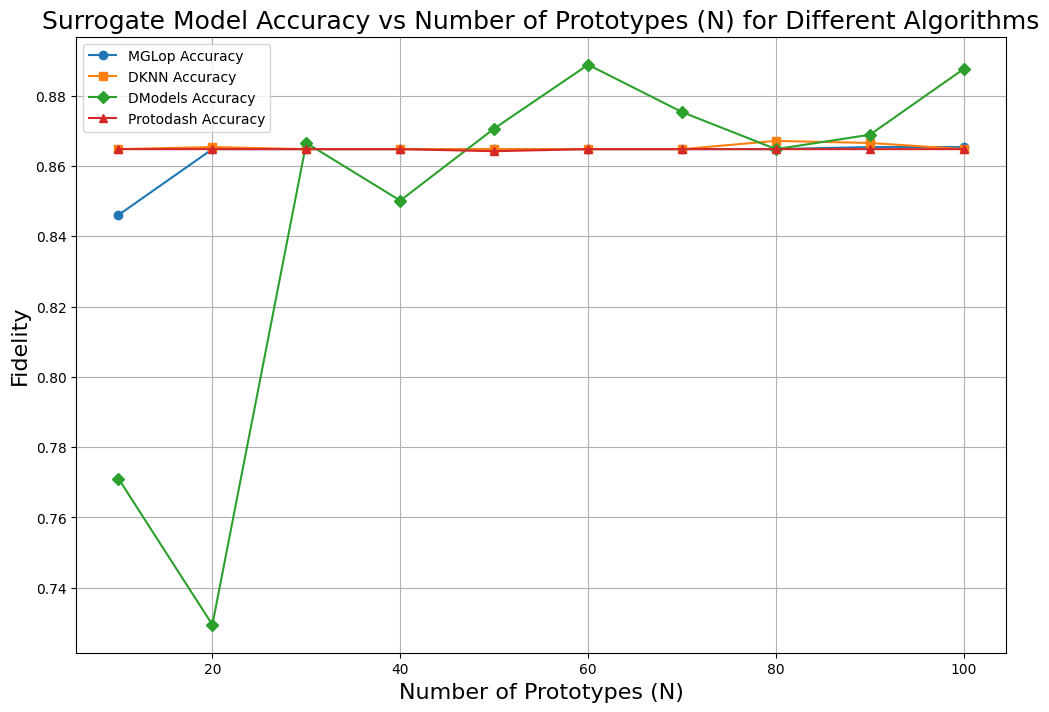

In [115]:
N_range=range(10,101,10)
plt.figure(figsize=(12, 8))
plt.plot(N_range, [item[2] for item in mglop_ev], marker='o', linestyle='-', label='MGLop Accuracy')
plt.plot(N_range, [item[2] for item in dknn_ev], marker='s', linestyle='-', label='DKNN Accuracy')
plt.plot(N_range, [item[2] for item in dmodels_ev], marker='D', linestyle='-', label='DModels Accuracy')
plt.plot(N_range, [item[2] for item in protodash_ev], marker='^', linestyle='-', label='Protodash Accuracy')

plt.xlabel("Number of Prototypes (N)", fontsize=16)
plt.ylabel("Fidelity", fontsize=16)
plt.title("Surrogate Model Accuracy vs Number of Prototypes (N) for Different Algorithms", fontsize=18)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.grid(True)
# plt.savefig("Figures/nearest_medoid_accuracy_plot.pdf", format="pdf")
plt.show()

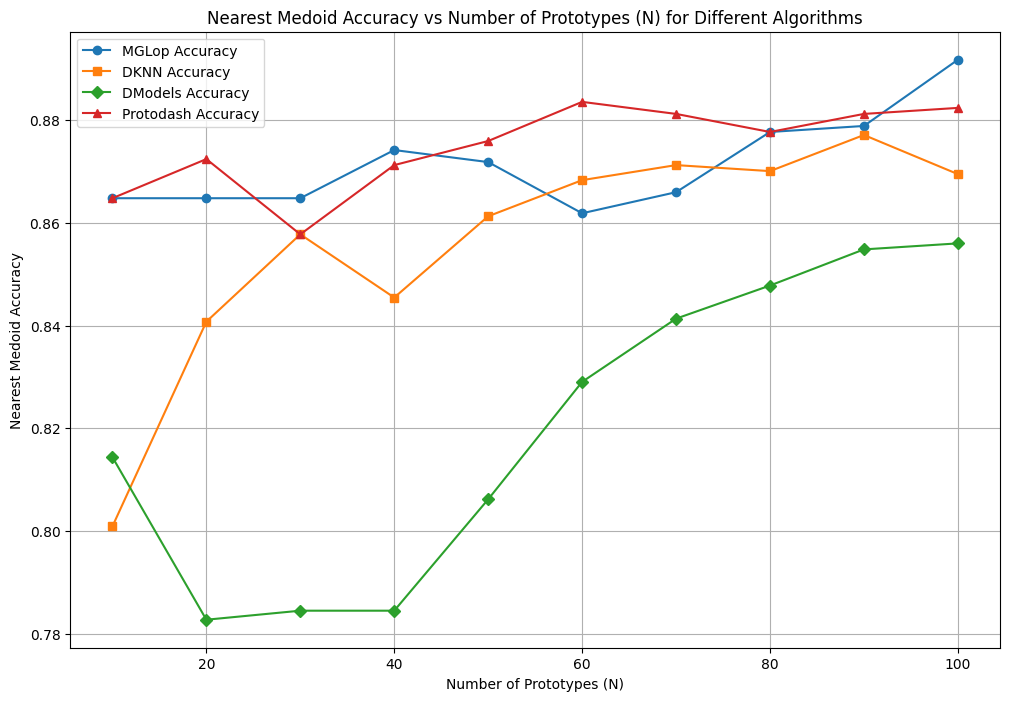

In [116]:
N_range=range(10,101,10)
plt.figure(figsize=(12, 8))
plt.plot(N_range, [item[0] for item in mglop_ev], marker='o', linestyle='-', label='MGLop Accuracy')
plt.plot(N_range, [item[0] for item in dknn_ev], marker='s', linestyle='-', label='DKNN Accuracy')
plt.plot(N_range, [item[0] for item in dmodels_ev], marker='D', linestyle='-', label='DModels Accuracy')
plt.plot(N_range, [item[0] for item in protodash_ev], marker='^', linestyle='-', label='Protodash Accuracy')

plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Nearest Medoid Accuracy")
plt.title("Nearest Medoid Accuracy vs Number of Prototypes (N) for Different Algorithms")
plt.legend()
plt.grid(True)
# plt.savefig("Figures/nearest_medoid_accuracy_plot.pdf", format="pdf")
plt.show()

100%|██████████| 10/10 [00:01<00:00,  5.25it/s]


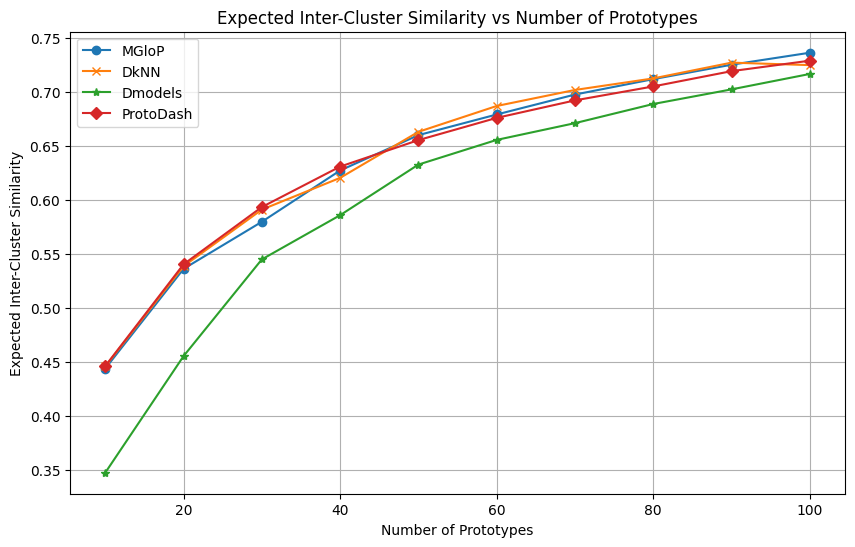

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


# Experiment with increasing number of prototypes
num_prototypes_list = range(10, 101, 10)
avg_similarities = []
avg_similarities1 = []
avg_similarities2 = []
avg_similarities3 = []

for i in tqdm(range(10)):
    mglop=list(all_protos_np[i].values())[0]
    dmodels=list(all_protos_np[i].values())[2]
    dknn=list(all_protos_np[i].values())[1]
    protodash=list(all_protos_np[i].values())[3]
    labels = cluster_by_prototypes(X_test, mglop)
    labels1 = cluster_by_prototypes(X_test, dknn)
    labels2 = cluster_by_prototypes(X_test, dmodels)
    labels3 = cluster_by_prototypes(X_test, protodash)
    avg_similarity = expected_inter_cluster_similarity(X_test, labels)
    avg_similarity1 = expected_inter_cluster_similarity(X_test, labels1)
    avg_similarity2 = expected_inter_cluster_similarity(X_test, labels2)
    avg_similarity3 = expected_inter_cluster_similarity(X_test, labels3)
    avg_similarities.append(avg_similarity)
    avg_similarities1.append(avg_similarity1)
    avg_similarities2.append(avg_similarity2)
    avg_similarities3.append(avg_similarity3)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_prototypes_list, avg_similarities, marker='o', label='MGloP')
plt.plot(num_prototypes_list, avg_similarities1, marker='x', label='DkNN')
plt.plot(num_prototypes_list, avg_similarities2, marker='*', label='Dmodels')
plt.plot(num_prototypes_list, avg_similarities3, marker='D', label='ProtoDash')
plt.xlabel('Number of Prototypes')
plt.ylabel('Expected Inter-Cluster Similarity')
plt.title('Expected Inter-Cluster Similarity vs Number of Prototypes')
plt.legend()
plt.grid(True)
plt.show()

In [146]:
aide_em=aide(influence_scores, X_train, X_test, 30, coverage=True)
# prs=find_representative_samples(X_test, X_train, influence_scores, 20, 30, alpha=0.6)
explainer = ProtodashExplainer()
weights, prs, _ = explainer.explain(X_test, X_test, m=20, kernelType = 'Gaussian')
# prs=find_prototypes(embeddings.detach(), mod_pred, 20)
distances = cosine_similarity(X_test, X_test[prs])
nearest_medoid_indices = np.argmax(distances, axis=1)

def coverage(N, bin=False, popularity=True):
    covs=[]
    for i in np.unique(nearest_medoid_indices):
        idx=np.where(nearest_medoid_indices == i)[0]
        if popularity:
            gx=[i[0] for i in Counter(np.array(aide_em)[idx].flatten()).most_common(60)]
        else:
            gx=aide_em[prs[i]]
        for j in idx:
            if bin:
                if len(set(aide_em[j]).intersection(set(gx)))>N:
                    covs.append(1)
                else:
                    covs.append(0)
            else:
                covs.append(len(set(aide_em[j]).intersection(set(gx)))/len(aide_em[j]))
    return sum(covs)/len(covs)

In [147]:
covs= [coverage(i, bin=True, popularity=False) for i in range(31)]

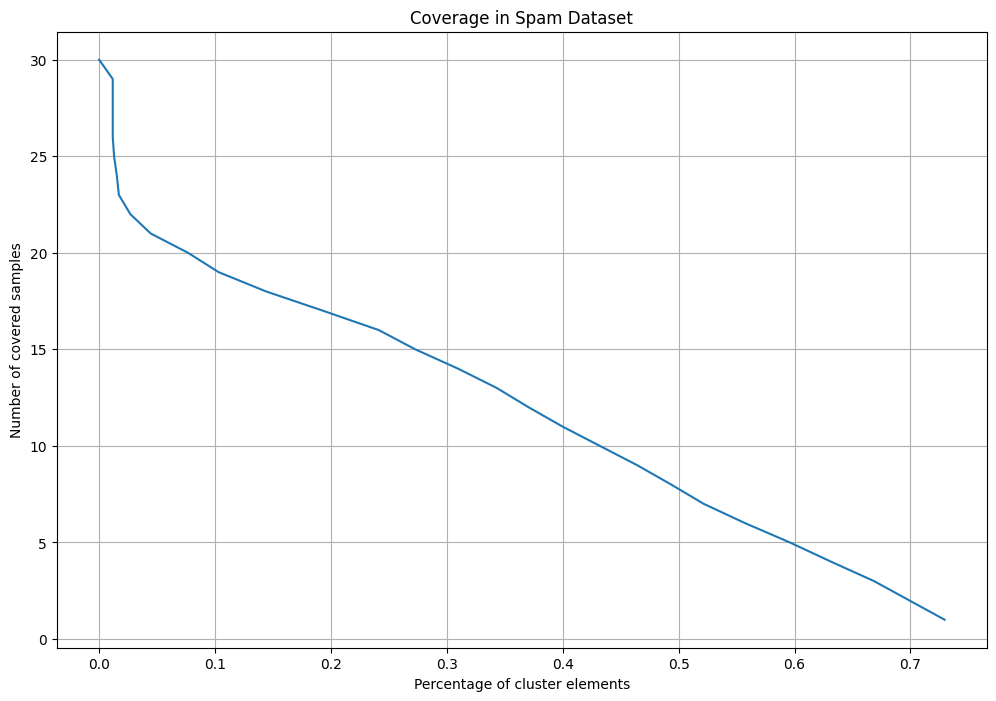

In [148]:
plt.figure(figsize=(12, 8))
plt.plot(covs[1:], range(1,31))
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.ylabel("Number of covered samples")
plt.xlabel("Percentage of cluster elements")
plt.title("Coverage in Spam Dataset")
plt.grid(True)

# Save the plot as a PDF
# plt.savefig("Figures/intersection_plot.pdf", format="pdf")

# Show the plot
plt.show()